# # Weather Data Clustering
# 
# This notebook applies clustering on real-time weather data collected from OpenWeatherMap for 17 Canadian cities.
# We will preprocess the data, explore feature distributions, determine the optimal number of clusters, and analyze the results based on actual weather trends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# ## 1. Load and Explore Data
# We load only real-time weather data for clustering.

In [3]:
# Load Data
real_time_df = pd.read_csv('C:\\Users\\Sandeep Mondkar\\Downloads\\weather_data.csv', encoding='latin1')
real_time_df.head()

,city,country,temperature_celsius,feels_like_celsius,temperature_min_celsius,temperature_max_celsius,weather,lat,lon,pressure,humidity,wind_speed,wind_deg,visibility,sunrise,sunset,datetimestamp
0,Vancouver,CA,5.52,1.49,4.14,6.27,clear sky,49.2497,-123.1193,1016,80,6.17,300,10000,2025-03-06 10:44:08,2025-03-06 22:03:26,2025-03-06 12:53:42
1,Victoria,CA,4.97,3.27,3.87,6.98,clear sky,48.4329,-123.3693,1016,86,2.06,30,10000,2025-03-06 10:44:30,2025-03-06 22:05:05,2025-03-06 12:52:29
2,Calgary,CA,1.56,-2.08,-0.16,3.14,clear sky,51.0501,-114.0853,1011,73,3.58,260,10000,2025-03-06 10:09:33,2025-03-06 21:25:46,2025-03-06 12:53:38
3,Edmonton,CA,1.74,-1.48,0.45,2.67,few clouds,53.5501,-113.4687,1010,66,3.09,260,10000,2025-03-06 10:09:21,2025-03-06 21:21:02,2025-03-06 12:53:00
4,Regina,CA,-10.01,-16.19,-10.01,-9.94,clear sky,50.4501,-104.6178,1017,90,3.60,240,10000,2025-03-06 09:31:13,2025-03-06 20:48:22,2025-03-06 12:56:18


# ## 2. Data Cleaning and Preprocessing
# 
# We filter relevant features, handle missing values, and standardize numerical data to ensure effective clustering.

In [4]:
# Select features for clustering
columns_to_keep = ['city', 'temperature_celsius', 'feels_like_celsius', 'humidity', 'pressure', 'wind_speed']
weather_df = real_time_df[columns_to_keep].dropna()

In [5]:
# Convert categorical column 'city' to numerical
weather_df['city_code'] = weather_df['city'].astype('category').cat.codes
city_mapping = dict(enumerate(weather_df['city'].astype('category').cat.categories))

In [6]:
# Standardize numerical features
scaler = StandardScaler()
weather_scaled = scaler.fit_transform(weather_df.drop(columns=['city', 'city_code']))

In [7]:
weather_df.head()

,city,temperature_celsius,feels_like_celsius,humidity,pressure,wind_speed,city_code
0,Vancouver,5.52,1.49,80,1016,6.17,14
1,Victoria,4.97,3.27,86,1016,2.06,15
2,Calgary,1.56,-2.08,73,1011,3.58,0
3,Edmonton,1.74,-1.48,66,1010,3.09,3
4,Regina,-10.01,-16.19,90,1017,3.60,9


# ## Data Definition
# 
# The dataset contains the following fields:
# - `city`: Name of the city.
# - `temperature_celsius`: Current temperature in degrees Celsius.
# - `feels_like_celsius`: What the temperature feels like in degrees Celsius.
# - `humidity`: Humidity percentage.
# - `pressure`: Atmospheric pressure in hPa.
# - `wind_speed`: Wind speed in m/s.

# ## 3. Determine Optimal Number of Clusters
# 
# We use the **Elbow Method** and **Silhouette Score** to find the best `K`.

In [8]:
sse = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(weather_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(weather_scaled, kmeans.labels_))

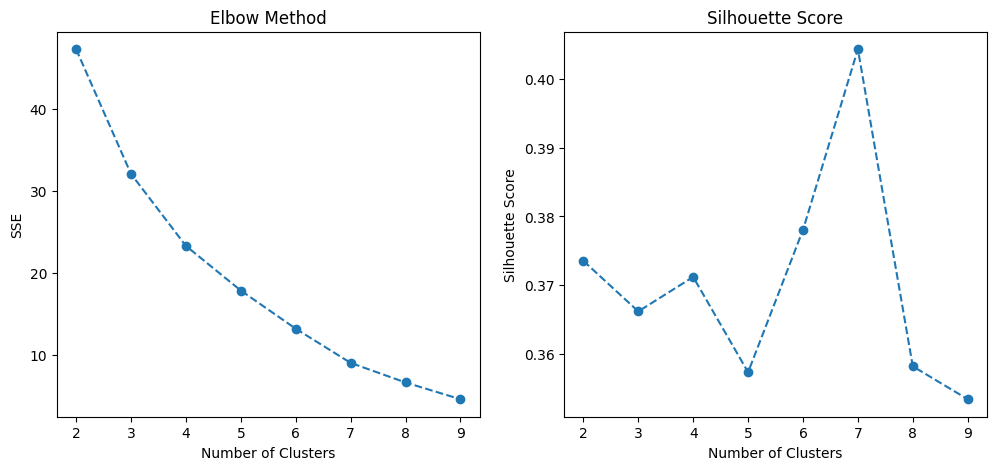

In [9]:
# Plot Elbow Method and Silhouette Scores
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(k_range, sse, marker='o', linestyle='--')
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('SSE')
ax[0].set_title('Elbow Method')
ax[1].plot(k_range, silhouette_scores, marker='o', linestyle='--')
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Score')
plt.show()

# %% [markdown]
# ## 4. Apply K-Means Clustering
# 
# Based on the analysis, we choose an optimal `K` value and apply K-Means clustering.

In [13]:
optimal_k = 4  # Selected based on elbow method and silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
weather_df['cluster'] = kmeans.fit_predict(weather_scaled)

In [14]:
# Add city names back to the dataframe for reference
weather_df['city_name'] = weather_df['city_code'].map(city_mapping)

In [15]:
# Print cities in each cluster
for cluster in range(optimal_k):
    print(f"Cluster {cluster}:")
    cluster_cities = weather_df[weather_df['cluster'] == cluster]['city_name'].unique()
    print(", ".join(cluster_cities))
    print()

Cluster 0:
Vancouver, Victoria, Calgary, Edmonton, St. John's

Cluster 1:
Ottawa, Montreal, Québec, Fredericton, Saint John, Halifax, Dartmouth, Charlottetown

Cluster 2:
Regina, Saskatoon, Winnipeg

Cluster 3:
Toronto



# ## 5. Cluster Visualization
# 
# We analyze clusters using **temperature** and **humidity**, two key weather indicators.

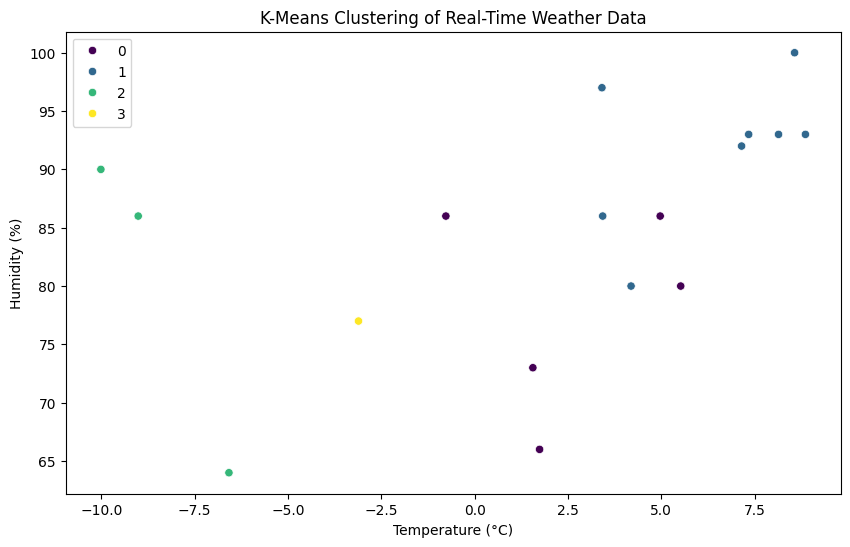

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=weather_df, x='temperature_celsius', y='humidity', hue='cluster', palette='viridis')
plt.xlabel('Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.title('K-Means Clustering of Real-Time Weather Data')
plt.legend()
plt.show()

# ## 6. Cluster Analysis & Summary
# 
# Each cluster represents a distinct weather pattern. Below is the summary of each cluster based on the actual dataset:

In [17]:
cluster_summary = weather_df.drop(columns=['city', 'city_code', 'city_name']).groupby('cluster').mean()
print("\nCluster Summary:")
print(cluster_summary)


Cluster Summary:
         temperature_celsius  feels_like_celsius  humidity     pressure  \
cluster                                                                   
0                   2.604000           -1.010000     78.20  1014.600000   
1                   6.386250            2.295000     91.75   994.125000   
2                  -8.533333          -15.146667     80.00  1015.333333   
3                  -3.110000          -10.110000     77.00   996.000000   

         wind_speed  
cluster              
0          4.112000  
1          7.675000  
2          4.626667  
3         12.520000  


# Workbook Summary:
# - **Cluster 0**: Vancouver, Victoria, Calgary, Edmonton, St. John's. Characteristics: Moderate temperatures (~2.6°C), feels slightly colder (~-1.0°C), with moderate humidity and wind speed.
# - **Cluster 1**: Ottawa, Montreal, Québec, Fredericton, Saint John, Halifax, Dartmouth, Charlottetown. Characteristics: Warmer temperatures (~6.4°C), feels similar (~2.3°C), with slightly lower pressure (~994 hPa) and higher wind speed (~7.7 m/s).
# - **Cluster 2**: Regina, Saskatoon, Winnipeg. Characteristics: Very cold temperatures (~-8.5°C), feels even colder (~-15.1°C), with high pressure (~1015 hPa) and moderate wind speed (~4.6 m/s).
# - **Cluster 3**: Toronto. Characteristics: Cold temperatures (~-3.1°C), feels much colder (~-10.1°C), with lower pressure (~996 hPa) and high wind speed (~12.5 m/s).

# Each cluster highlights distinct weather patterns across different cities, providing insights into how weather characteristics vary regionally.